# NLP Classification
By : Hesham Asem

_____

we have 2 files sheet 1 & sheet 2

sheet 1 contain 80 replies from users to chatbot , & it either classied as offensive (flagged) or non-offensive (not flagged)

and sheet 2 contain 125 resumes , some of them looks unreal so it flagged & some are real : not flagged

we need to use NLP techniques to train our model , so he can be able to diffrentiate between them 


Data File : https://www.kaggle.com/samdeeplearning/deepnlp

let's first import needed libraries



In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid")
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import collections
import spacy
nlp = spacy.load('en_core_web_sm')


and read both files

In [2]:
ResponseData = pd.read_csv("Sheet_1.csv",encoding='latin-1')
ResumeData = pd.read_csv("Sheet_2.csv",encoding='latin-1')

so we'll start witjh responses file 

_____


# Response File

let's have a look to the file

In [3]:
ResponseData.head()

,response_id,class,response_text,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,response_1,not_flagged,I try and avoid this sort of conflict,NaN,NaN,NaN,NaN,NaN
1,response_2,flagged,Had a friend open up to me about his mental ad...,NaN,NaN,NaN,NaN,NaN
2,response_3,flagged,I saved a girl from suicide once. She was goin...,NaN,NaN,NaN,NaN,NaN
3,response_4,not_flagged,i cant think of one really...i think i may hav...,NaN,NaN,NaN,NaN,NaN
4,response_5,not_flagged,Only really one friend who doesn't fit into th...,,NaN,NaN,NaN,NaN


we'll just need 2 columns , which is response_text as X & class as y , let's drop the rest 

In [4]:
ResponseData.drop(['response_id','Unnamed: 3', 'Unnamed: 4','Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7'],axis=1, inplace=True)
ResponseData.head()

,class,response_text
0,not_flagged,I try and avoid this sort of conflict
1,flagged,Had a friend open up to me about his mental ad...
2,flagged,I saved a girl from suicide once. She was goin...
3,not_flagged,i cant think of one really...i think i may hav...
4,not_flagged,Only really one friend who doesn't fit into th...


what is the shape ? 

In [5]:
ResponseData.shape

(80, 2)

does it contain any nulls ? 

In [6]:
ResponseData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 2 columns):
class            80 non-null object
response_text    80 non-null object
dtypes: object(2)
memory usage: 1.3+ KB


great , now how many flagged & non-flagged we have here ? 

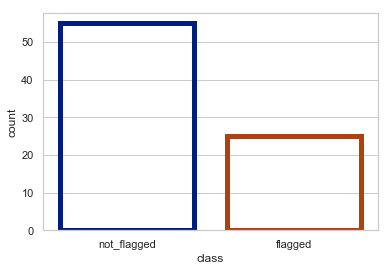

In [7]:
sns.countplot(x='class', data=ResponseData ,facecolor=(0, 0, 0, 0),linewidth=5,edgecolor=sns.color_palette("dark", 3))

suitable ratios , now let's define the cloud function , to show most repeated words in each sector

In [8]:
def cloud(text):
    plt.figure(figsize=(15,15))
    plt.imshow(WordCloud(background_color="white",stopwords=set(stopwords.words('english')))
               .generate(" ".join([i for i in text.str.lower()])))
    plt.axis("off")
    plt.title("Response could words")

now we can show most repeated words in flagged reponses

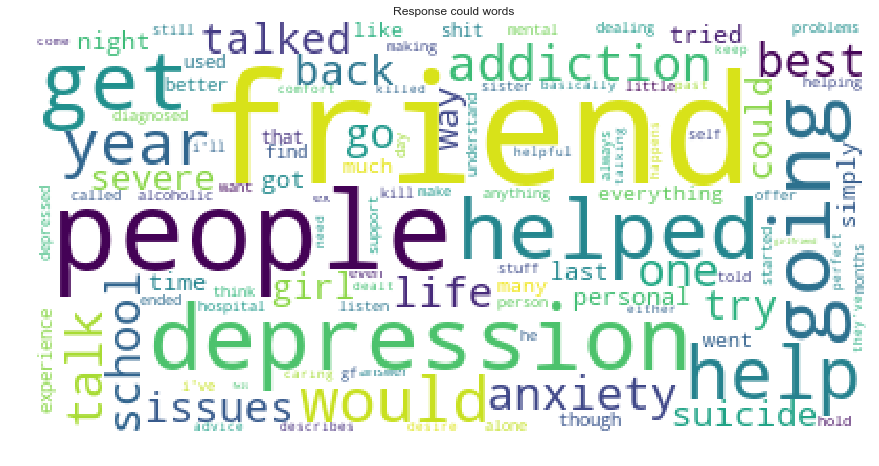

In [9]:
cloud(ResponseData[ResponseData['class']=='flagged']['response_text'])

many related words appear like : suicide , anxiety , addiction 

now how not-flagged looks like

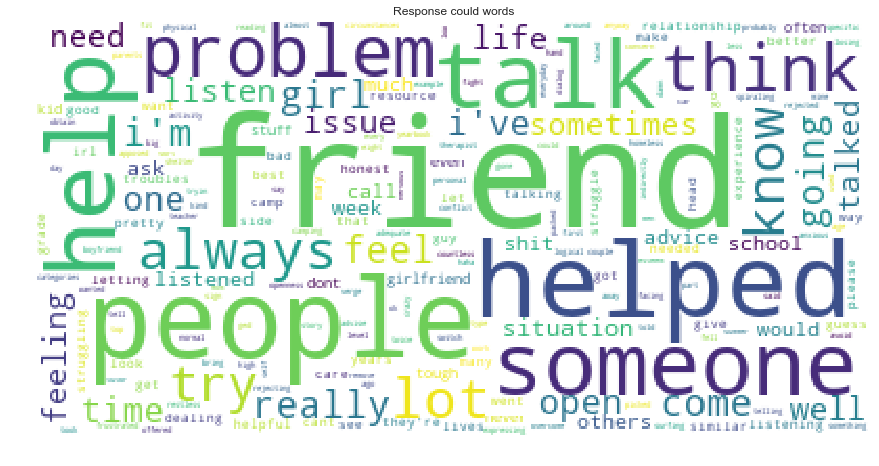

In [10]:
cloud(ResponseData[ResponseData['class']=='not_flagged']['response_text'])

many normal words appear . 

but since several words appeared here , so it might mislead the training , so we have to know most common words , then remove them since they are like stop words

so we we'll define a function to know most common words

In [11]:
def CommonWords(text , kk=10) : 

    all_words = []

    for i in range(text.shape[0]) : 
        this_phrase = list(text)[i]
        for word in this_phrase.split() : 
            all_words.append(word)

    print(f'Total words are {len(all_words)} words')   
    print('')

    common_words = collections.Counter(all_words).most_common()
    k=0
    word_list =[]
    for word, i in common_words : 
        if not word.lower() in  nlp.Defaults.stop_words :
            print(f'The word is   {word}   repeated   {i}  times')
            word_list.append(word)
            k+=1
        if k==kk : 
            break
            
    return word_list

then here . we'll get most common 5 words in not flagged responses

In [12]:
words1 = CommonWords(ResponseData[ResponseData['class']=='not_flagged']['response_text'],5)

Total words are 1238 words

The word is   friends   repeated   12  times
The word is   people   repeated   10  times
The word is   friend   repeated   9  times
The word is   helped   repeated   8  times
The word is   talk   repeated   7  times


and here most common 5 words in flagged

In [13]:
words2 = CommonWords(ResponseData[ResponseData['class']=='flagged']['response_text'],5)

Total words are 1260 words

The word is   friend   repeated   11  times
The word is   people   repeated   9  times
The word is   friends   repeated   8  times
The word is   helped   repeated   6  times
The word is   help   repeated   6  times


now we camn add the two lists 

In [14]:
filtered_words = words1+words2
filtered_words

['friends',
 'people',
 'friend',
 'helped',
 'talk',
 'friend',
 'people',
 'friends',
 'helped',
 'help']

then define the removal function 

In [15]:
def RemoveWords(data , feature , new_feature, words_list ) : 
    new_column = []
    for i in range(data.shape[0]) : 
        this_phrase = data[feature][i]
        new_phrase = []
        for word in this_phrase.split() : 
            if not word.lower() in words_list : 
                new_phrase.append(word)
        new_column.append(' '.join(new_phrase))
    
    data.insert(data.shape[1],new_feature,new_column)

now to remove these words & make a new column call filtered_text

In [16]:
RemoveWords(ResponseData , 'response_text' , 'filtered_text' , filtered_words)

now how data looks like

In [17]:
ResponseData.head()

,class,response_text,filtered_text
0,not_flagged,I try and avoid this sort of conflict,I try and avoid this sort of conflict
1,flagged,Had a friend open up to me about his mental ad...,Had a open up to me about his mental addiction...
2,flagged,I saved a girl from suicide once. She was goin...,I saved a girl from suicide once. She was goin...
3,not_flagged,i cant think of one really...i think i may hav...,i cant think of one really...i think i may hav...
4,not_flagged,Only really one friend who doesn't fit into th...,Only really one who doesn't fit into the any o...


& even we can make cloud again for flagged responses

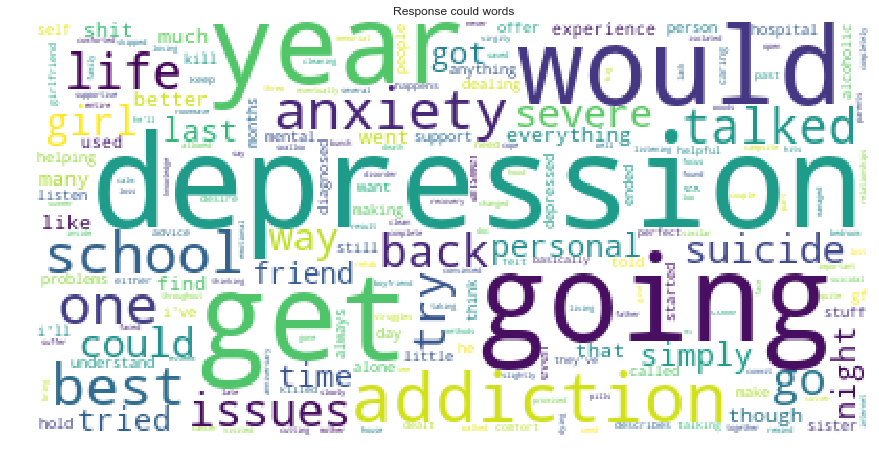

In [18]:
cloud(ResponseData[ResponseData['class']=='flagged']['filtered_text'])

now words are more representative 

& cloud for nonflagged responses

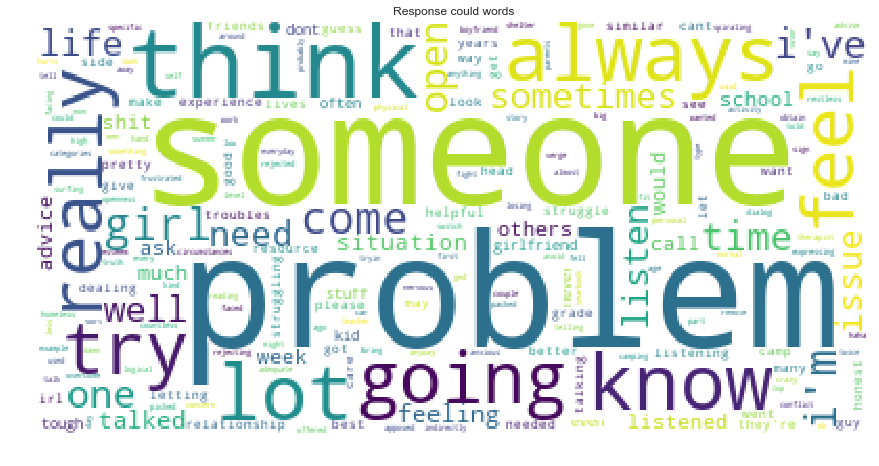

In [19]:
cloud(ResponseData[ResponseData['class']=='not_flagged']['filtered_text'])

great , now we need to label encode the output

In [20]:
enc  = LabelEncoder()
enc.fit(ResponseData['class'])
ResponseData['class'] = enc.transform(ResponseData['class'])

how data looks like ? 

In [21]:
ResponseData.head()

,class,response_text,filtered_text
0,1,I try and avoid this sort of conflict,I try and avoid this sort of conflict
1,0,Had a friend open up to me about his mental ad...,Had a open up to me about his mental addiction...
2,0,I saved a girl from suicide once. She was goin...,I saved a girl from suicide once. She was goin...
3,1,i cant think of one really...i think i may hav...,i cant think of one really...i think i may hav...
4,1,Only really one friend who doesn't fit into th...,Only really one who doesn't fit into the any o...


then we define X & y

In [22]:
X = ResponseData['filtered_text']
y = ResponseData['class']

how is X & y shapes ? 

In [23]:
X.shape

(80,)

In [24]:
y.shape

(80,)

then apply count vectorizer to make the sparse matrix to X

In [25]:
VecModel = TfidfVectorizer()
X = VecModel.fit_transform(X)

print(f'The new shape for X is {X.shape}')

The new shape for X is (80, 660)


and split the data

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=402)

In [27]:
print('X_train shape is ' , X_train.shape)
print('X_test shape is ' , X_test.shape)
print('y_train shape is ' , y_train.shape)
print('y_test shape is ' , y_test.shape)

X_train shape is  (60, 660)
X_test shape is  (20, 660)
y_train shape is  (60,)
y_test shape is  (20,)


let's use Decision Tree Classifier , with gini criterion& depth 10

In [28]:
DecisionTreeClassifierModel = DecisionTreeClassifier(criterion='gini',max_depth=10,random_state=33) 
DecisionTreeClassifierModel.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=33,
            splitter='best')

how is scores ? 

In [29]:
print('DecisionTreeClassifierModel Train Score is : ' , DecisionTreeClassifierModel.score(X_train, y_train))
print('DecisionTreeClassifierModel Test Score is : ' , DecisionTreeClassifierModel.score(X_test, y_test))
print('DecisionTreeClassifierModel Classes are : ' , DecisionTreeClassifierModel.classes_)

DecisionTreeClassifierModel Train Score is :  1.0
DecisionTreeClassifierModel Test Score is :  0.9
DecisionTreeClassifierModel Classes are :  [0 1]


ok 90% is fine enough , let's predict some result

In [30]:
y_pred = DecisionTreeClassifierModel.predict(X_test)
y_pred_prob = DecisionTreeClassifierModel.predict_proba(X_test)
print('Predicted Value for DecisionTreeClassifierModel is : ' , y_pred[:10])
print('Prediction Probabilities Value for DecisionTreeClassifierModel is : ' , y_pred_prob[:10])

Predicted Value for DecisionTreeClassifierModel is :  [0 1 1 1 1 1 1 1 1 0]
Prediction Probabilities Value for DecisionTreeClassifierModel is :  [[1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]


also we can use the model to predict new phrases we just invent now

let's form a normal phrase , it should classified as not-flagged

In [31]:
phrase = ['I went to my friend to talk about normal issues']
enc.inverse_transform(DecisionTreeClassifierModel.predict(VecModel.transform(phrase)))

array(['not_flagged'], dtype=object)

great , now to form a weired phrase which looks like offensive

In [32]:
phrase = ['I know a Friend was thinking about suicide']
enc.inverse_transform(DecisionTreeClassifierModel.predict(VecModel.transform(phrase)))

array(['flagged'], dtype=object)

good job , not let's move to Resume Data , to apply same steps

______

# Resume Data

we'll apply almost same steps here , as we did in responses 

In [33]:
ResumeData.head()

,resume_id,class,resume_text
0,resume_1,not_flagged,\rCustomer Service Supervisor/Tier - Isabella ...
1,resume_2,not_flagged,\rEngineer / Scientist - IBM Microelectronics ...
2,resume_3,not_flagged,\rLTS Software Engineer Computational Lithogra...
3,resume_4,not_flagged,TUTOR\rWilliston VT - Email me on Indeed: ind...
4,resume_5,flagged,\rIndependent Consultant - Self-employed\rBurl...


In [34]:
ResumeData.shape

(125, 3)

In [35]:
ResumeData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 3 columns):
resume_id      125 non-null object
class          125 non-null object
resume_text    125 non-null object
dtypes: object(3)
memory usage: 3.0+ KB


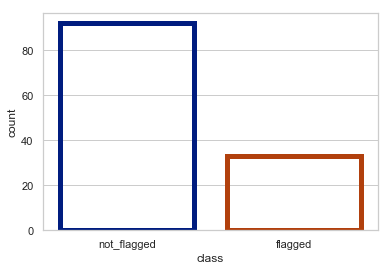

In [36]:
sns.countplot(x='class', data=ResumeData ,facecolor=(0, 0, 0, 0),linewidth=5,edgecolor=sns.color_palette("dark", 3))

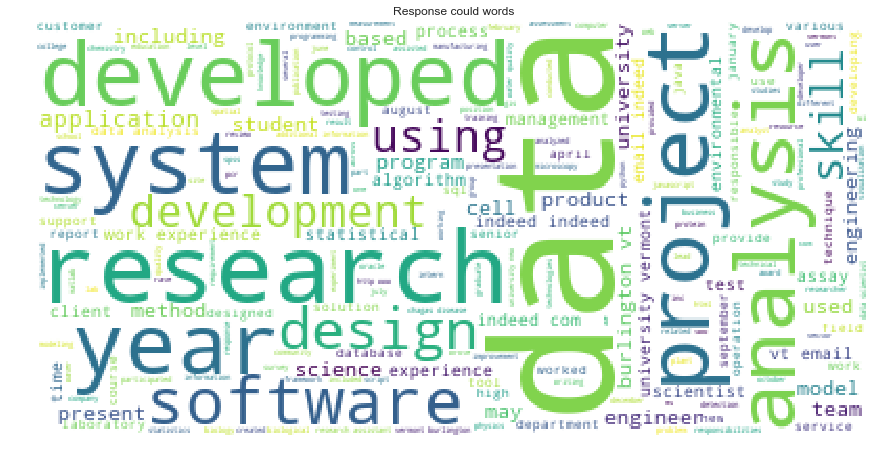

In [37]:
cloud(ResumeData[ResumeData['class']=='flagged']['resume_text'])

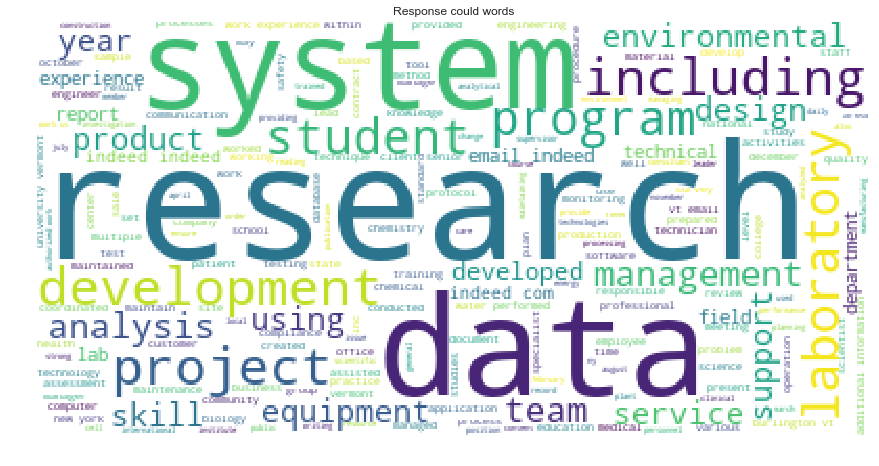

In [38]:
cloud(ResumeData[ResumeData['class']=='not_flagged']['resume_text'])

In [39]:
words1 = CommonWords(ResumeData[ResumeData['class']=='flagged']['resume_text'],10)

Total words are 25482 words

The word is   -   repeated   529  times
The word is   ¢   repeated   471  times
The word is   data   repeated   138  times
The word is   VT   repeated   119  times
The word is   University   repeated   117  times
The word is   Research   repeated   85  times
The word is   analysis   repeated   71  times
The word is   Developed   repeated   64  times
The word is   Vermont   repeated   61  times
The word is   software   repeated   60  times


In [40]:
words2 = CommonWords(ResumeData[ResumeData['class']=='not_flagged']['resume_text'],10)

Total words are 67695 words

The word is   -   repeated   1492  times
The word is   ¢   repeated   1214  times
The word is   VT   repeated   329  times
The word is   *   repeated   266  times
The word is   University   repeated   236  times
The word is   data   repeated   208  times
The word is   Research   repeated   190  times
The word is   research   repeated   172  times
The word is   &   repeated   169  times
The word is   including   repeated   156  times


In [41]:
filtered_words = words1+words2
filtered_words

['-',
 '\x8a\x97¢',
 'data',
 'VT',
 'University',
 'Research',
 'analysis',
 'Developed',
 'Vermont',
 'software',
 '-',
 '\x8a\x97¢',
 'VT',
 '*',
 'University',
 'data',
 'Research',
 'research',
 '&',
 'including']

In [42]:
RemoveWords(ResumeData , 'resume_text' , 'filtered_text' , filtered_words)
ResumeData.head()

,resume_id,class,resume_text,filtered_text
0,resume_1,not_flagged,\rCustomer Service Supervisor/Tier - Isabella ...,Customer Service Supervisor/Tier Isabella Cata...
1,resume_2,not_flagged,\rEngineer / Scientist - IBM Microelectronics ...,Engineer / Scientist IBM Microelectronics Divi...
2,resume_3,not_flagged,\rLTS Software Engineer Computational Lithogra...,LTS Engineer Computational Lithography IBM Cor...
3,resume_4,not_flagged,TUTOR\rWilliston VT - Email me on Indeed: ind...,TUTOR Williston VT Email me on Indeed: indeed....
4,resume_5,flagged,\rIndependent Consultant - Self-employed\rBurl...,Independent Consultant Self-employed Burlingto...


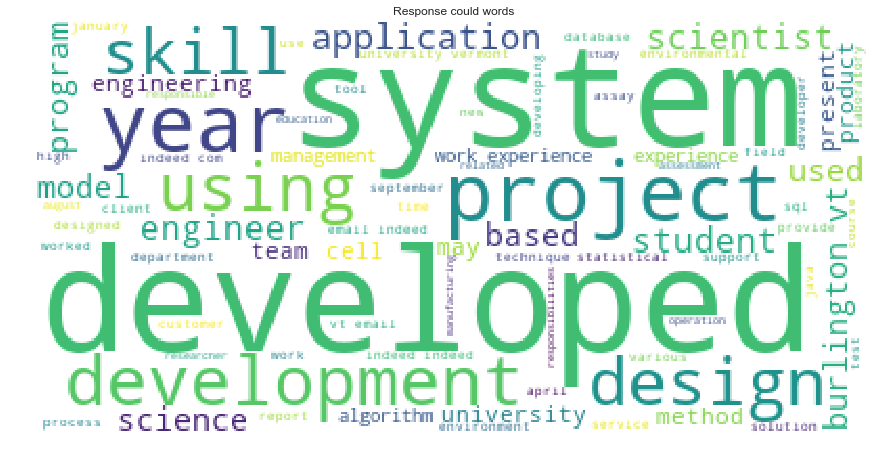

In [43]:
cloud(ResumeData[ResumeData['class']=='flagged']['filtered_text'])

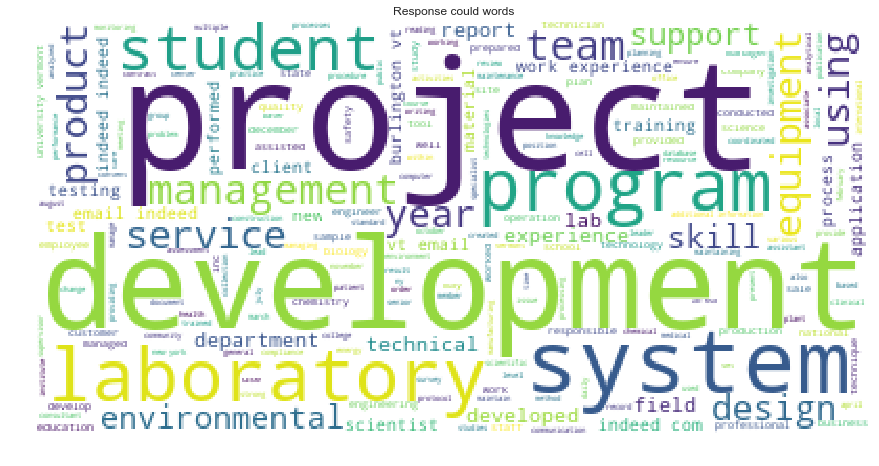

In [44]:
cloud(ResumeData[ResumeData['class']=='not_flagged']['filtered_text'])

In [45]:
enc.fit(ResumeData['class'])
ResumeData['class'] = enc.transform(ResumeData['class'])
ResumeData.head()

,resume_id,class,resume_text,filtered_text
0,resume_1,1,\rCustomer Service Supervisor/Tier - Isabella ...,Customer Service Supervisor/Tier Isabella Cata...
1,resume_2,1,\rEngineer / Scientist - IBM Microelectronics ...,Engineer / Scientist IBM Microelectronics Divi...
2,resume_3,1,\rLTS Software Engineer Computational Lithogra...,LTS Engineer Computational Lithography IBM Cor...
3,resume_4,1,TUTOR\rWilliston VT - Email me on Indeed: ind...,TUTOR Williston VT Email me on Indeed: indeed....
4,resume_5,0,\rIndependent Consultant - Self-employed\rBurl...,Independent Consultant Self-employed Burlingto...


In [46]:
X = ResumeData['filtered_text']
y = ResumeData['class']

In [47]:
X.shape

(125,)

In [48]:
y.shape

(125,)

In [49]:
X = VecModel.fit_transform(X)

print(f'The new shape for X is {X.shape}')

The new shape for X is (125, 11466)


In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=102)
print('X_train shape is ' , X_train.shape)
print('X_test shape is ' , X_test.shape)
print('y_train shape is ' , y_train.shape)
print('y_test shape is ' , y_test.shape)

X_train shape is  (100, 11466)
X_test shape is  (25, 11466)
y_train shape is  (100,)
y_test shape is  (25,)


here we'll use SVC since it will make better accuracy 

In [51]:
SVCModel = SVC(kernel= 'linear',# it can be also linear,poly,sigmoid,precomputed
               max_iter=10000,C=10,gamma='auto')
SVCModel.fit(X_train, y_train)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=10000, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [52]:
print('SVCModel Train Score is : ' , SVCModel.score(X_train, y_train))
print('SVCModel Test Score is : ' , SVCModel.score(X_test, y_test))

SVCModel Train Score is :  1.0
SVCModel Test Score is :  0.84


In [53]:
y_pred = SVCModel.predict(X_test)
print('Predicted Value for SVCModel is : ' , y_pred[:10])

Predicted Value for SVCModel is :  [1 1 1 1 1 0 1 1 1 1]
